# Load in data

In [1]:
# import pandas numpy and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# format display
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
# cell usually takes 40 sec to run

# read in the data
root = 'data/'
train = pd.read_parquet(root + 'train_series.parquet')
test = pd.read_parquet(root + 'test_series.parquet')
events = pd.read_csv(root + 'train_events.csv')
submission = pd.read_csv(root + 'sample_submission.csv')

# Inspect some data

In [ ]:
# convert 'timestamp' column to datetime
# train['timestamp'] = pd.to_datetime(train['timestamp'])
# test['timestamp'] = pd.to_datetime(test['timestamp'])
# events['timestamp'] = pd.to_datetime(events['timestamp'])

## Training data

In [85]:
# look at first few rows of train
train.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.637,0.022
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.637,0.022
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637,0.022
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.637,0.021
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.637,0.022


In [4]:
# dtypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   series_id  object 
 1   step       uint32 
 2   timestamp  object 
 3   anglez     float32
 4   enmo       float32
dtypes: float32(2), object(2), uint32(1)
memory usage: 3.3+ GB


In [5]:
train.shape

(127946340, 5)

In [6]:
# look at nulls
train.isna().sum()

series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64

__127m__ rows (no nulls) where each row represents a user at a 5-second interval.

---

Columns are as follows:
- __<ins>series_id</ins>__: unique id for each user
- __<ins>step</ins>__: time step (0 is moment that user began using device) 
- __<ins>timestamp</ins>__: time of event
- __<ins>anglez</ins>__: "z-angle". Angle of arm relative to the vertical axis of the body
- __<ins>enmo</ins>__: quantifies physical activity. Very low values (close to 0) indicate sleep or rest


In [13]:
# unique series_id
train['series_id'].nunique()

277

- 277 unique users

## Events
- essentially the labels for the training data

In [8]:
events.head(10)

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
5,038441c925bb,3,wakeup,44400.0,2018-08-17T05:10:00-0400
6,038441c925bb,4,onset,57240.0,2018-08-17T23:00:00-0400
7,038441c925bb,4,wakeup,62856.0,2018-08-18T06:48:00-0400
8,038441c925bb,5,onset,NaN,NaN
9,038441c925bb,5,wakeup,NaN,NaN


In [11]:
events.shape

(14508, 5)

In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  int64  
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.8+ KB


In [10]:
# look at unique events in event
events['event'].unique()

array(['onset', 'wakeup'], dtype=object)

- __14.5k rows__. Half are onset times, half are wakeup times. __7254 total days__, about __4800 days__ of training data with labels (non null)
- Each user has a onset and wakeup time once per day
- Null values in the step and timestamp cols indicate that no sleep was detected (device wasn't worn)

In [7]:
# group rows by user
events_grouped = events.groupby('series_id')

# add tot_nights col equal to last 'night' value for each series_id
events['tot_nights'] = events_grouped['night'].transform('last')

# add missing sleep column
events['missing_sleep'] = events.step.isna()

# add tot_nights_missed, divide by 2 because each night is 2 rows
events['tot_nights_missed'] = events_grouped['missing_sleep'].transform('sum').div(2).astype(int)

In [8]:
# check
events.head()

,series_id,night,event,step,timestamp,tot_nights,missing_sleep,tot_nights_missed
0,038441c925bb,1,onset,4992.000,2018-08-14T22:26:00-0400,23,False,4
1,038441c925bb,1,wakeup,10932.000,2018-08-15T06:41:00-0400,23,False,4
2,038441c925bb,2,onset,20244.000,2018-08-15T19:37:00-0400,23,False,4
3,038441c925bb,2,wakeup,27492.000,2018-08-16T05:41:00-0400,23,False,4
4,038441c925bb,3,onset,39996.000,2018-08-16T23:03:00-0400,23,False,4


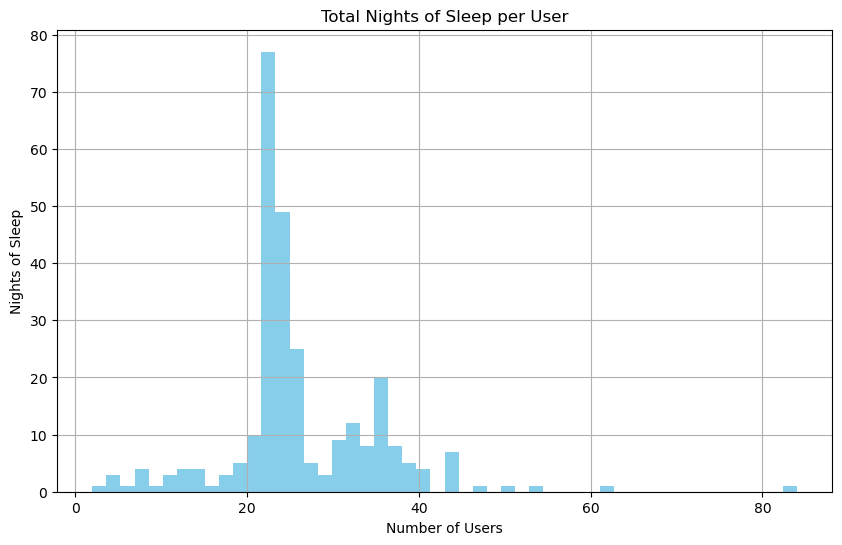

In [70]:
# plot nights of sleep per user
fig, ax = plt.subplots(figsize=(10, 6))
events_grouped['tot_nights'].mean().hist(bins=50, ax=ax, color='skyblue')
ax.set_title('Total Nights of Sleep per User')
ax.set_ylabel('Nights of Sleep')
ax.set_xlabel('Number of Users');

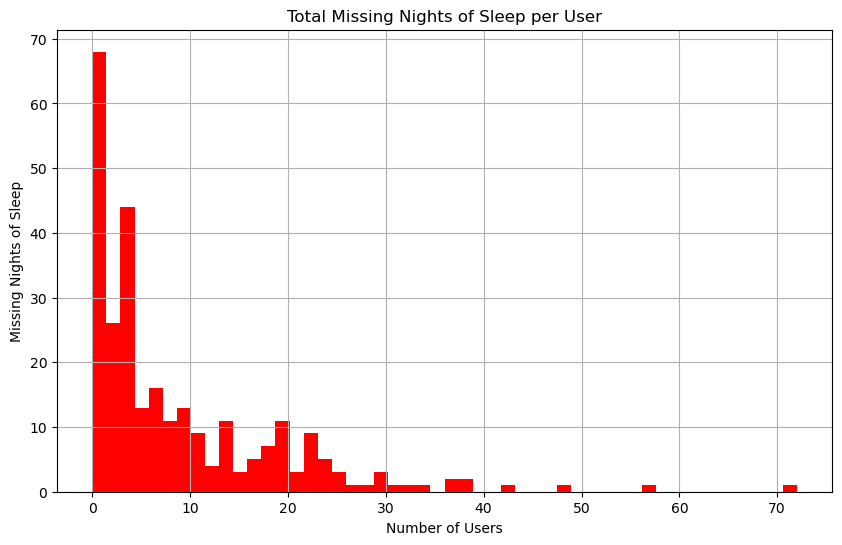

In [71]:
# plot missing nights of sleep per user
fig, ax = plt.subplots(figsize=(10, 6))
events_grouped['tot_nights_missed'].mean().hist(bins=50, ax=ax, color='red')
ax.set_title('Total Missing Nights of Sleep per User')
ax.set_ylabel('Missing Nights of Sleep')
ax.set_xlabel('Number of Users');

In [74]:
# look at users with most missing nights of sleep
events_grouped['tot_nights_missed'].mean().sort_values(ascending=False).head()

series_id
78569a801a38   72.000
f564985ab692   57.000
fb223ed2278c   48.000
c107b5789660   42.000
cfeb11428dd7   38.000
Name: tot_nights_missed, dtype: float64

In [75]:
# user with most missed sleep: recorded first 12 nights, then missed 72
events[(events['series_id'] == '78569a801a38') & (events['event'] == 'onset')].head(100)

,series_id,night,event,step,timestamp,missing_sleep,tot_nights,tot_nights_missed
6456,78569a801a38,1,onset,5496.000,2017-08-18T00:23:00-0400,False,84,72
6458,78569a801a38,2,onset,22488.000,2017-08-18T23:59:00-0400,False,84,72
6460,78569a801a38,3,onset,42192.000,2017-08-20T03:21:00-0400,False,84,72
6462,78569a801a38,4,onset,57924.000,2017-08-21T01:12:00-0400,False,84,72
6464,78569a801a38,5,onset,74364.000,2017-08-22T00:02:00-0400,False,84,72
6466,78569a801a38,6,onset,92280.000,2017-08-23T00:55:00-0400,False,84,72
6468,78569a801a38,7,onset,108960.000,2017-08-24T00:05:00-0400,False,84,72
6470,78569a801a38,8,onset,125760.000,2017-08-24T23:25:00-0400,False,84,72
6472,78569a801a38,9,onset,143028.000,2017-08-25T23:24:00-0400,False,84,72
6474,78569a801a38,10,onset,160596.000,2017-08-26T23:48:00-0400,False,84,72


- In the end, we may be able to drop all missing rows

# Visualize
- Look at anglez and enmo on different days for a specific user

In [93]:
# get a single user, convert to datetime
example_user = '038441c925bb'
train_example = train.loc[train['series_id'] == example_user].reset_index(drop=True)
train_example['timestamp'] = pd.to_datetime(train_example['timestamp'], utc=True)

# create date col for plotting
train_example['date'] = train_example['timestamp'].dt.date

In [94]:
# check
train_example.tail()

,series_id,step,timestamp,anglez,enmo,date
389875,038441c925bb,389875,2018-09-06 08:59:35+00:00,-27.374,0.011,2018-09-06
389876,038441c925bb,389876,2018-09-06 08:59:40+00:00,-27.494,0.011,2018-09-06
389877,038441c925bb,389877,2018-09-06 08:59:45+00:00,-27.534,0.011,2018-09-06
389878,038441c925bb,389878,2018-09-06 08:59:50+00:00,-28.004,0.011,2018-09-06
389879,038441c925bb,389879,2018-09-06 08:59:55+00:00,-28.657,0.013,2018-09-06


In [95]:
# look at user's labels in events table
events[events['series_id'] == example_user]

,series_id,night,event,step,timestamp,tot_nights,missing_sleep,tot_nights_missed
0,038441c925bb,1,onset,4992.000,2018-08-14T22:26:00-0400,23,False,4
1,038441c925bb,1,wakeup,10932.000,2018-08-15T06:41:00-0400,23,False,4
2,038441c925bb,2,onset,20244.000,2018-08-15T19:37:00-0400,23,False,4
3,038441c925bb,2,wakeup,27492.000,2018-08-16T05:41:00-0400,23,False,4
4,038441c925bb,3,onset,39996.000,2018-08-16T23:03:00-0400,23,False,4
5,038441c925bb,3,wakeup,44400.000,2018-08-17T05:10:00-0400,23,False,4
6,038441c925bb,4,onset,57240.000,2018-08-17T23:00:00-0400,23,False,4
7,038441c925bb,4,wakeup,62856.000,2018-08-18T06:48:00-0400,23,False,4
8,038441c925bb,5,onset,NaN,NaN,23,True,4
9,038441c925bb,5,wakeup,NaN,NaN,23,True,4


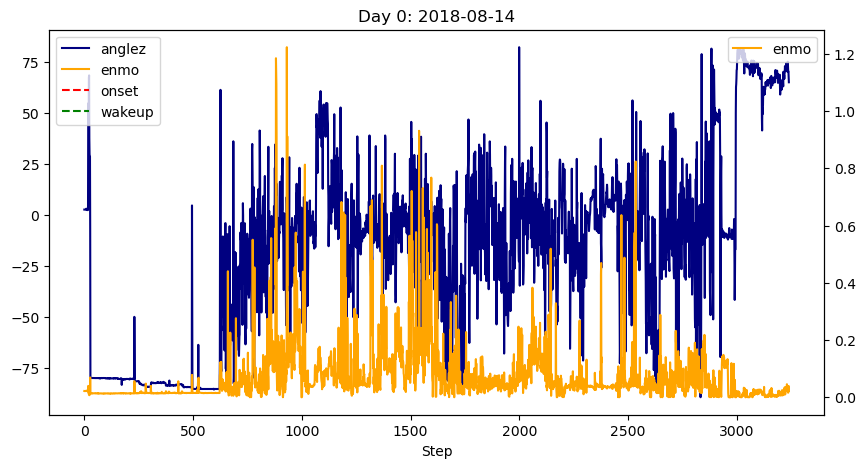

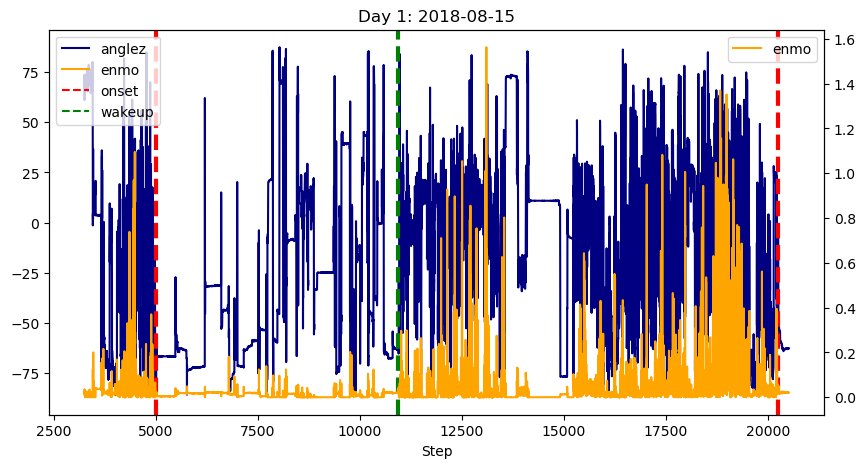

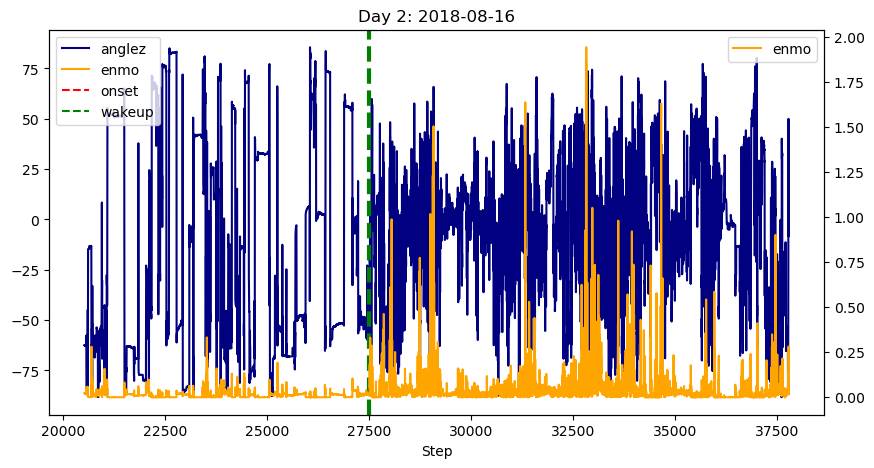

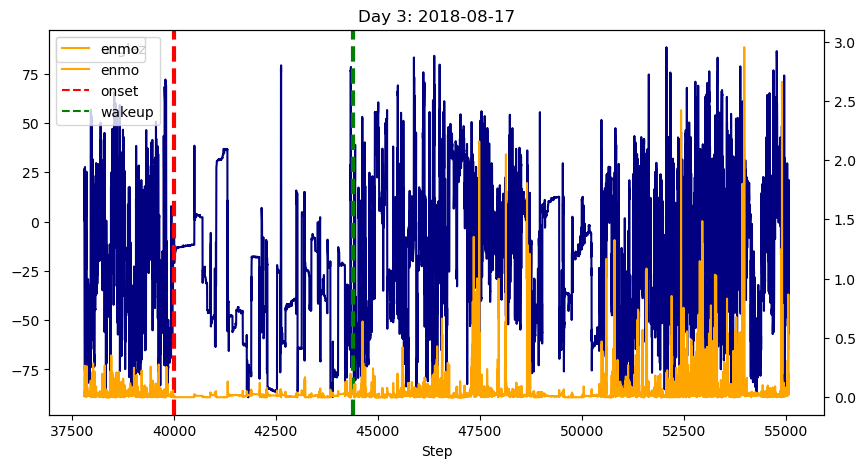

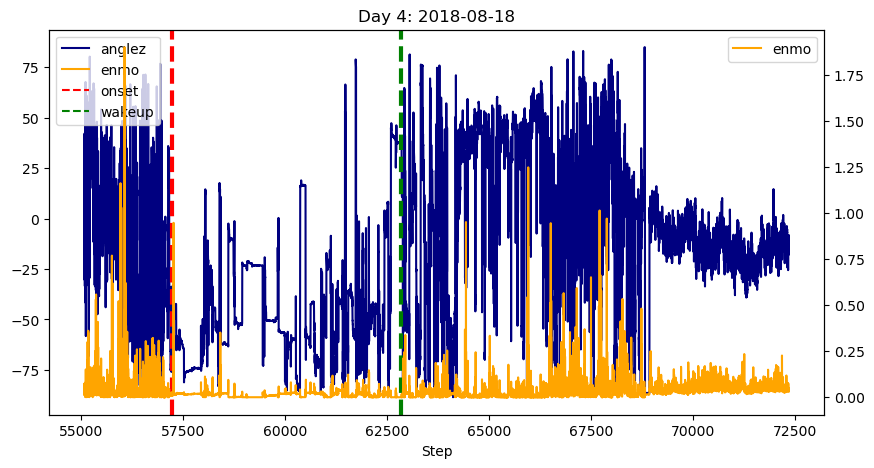

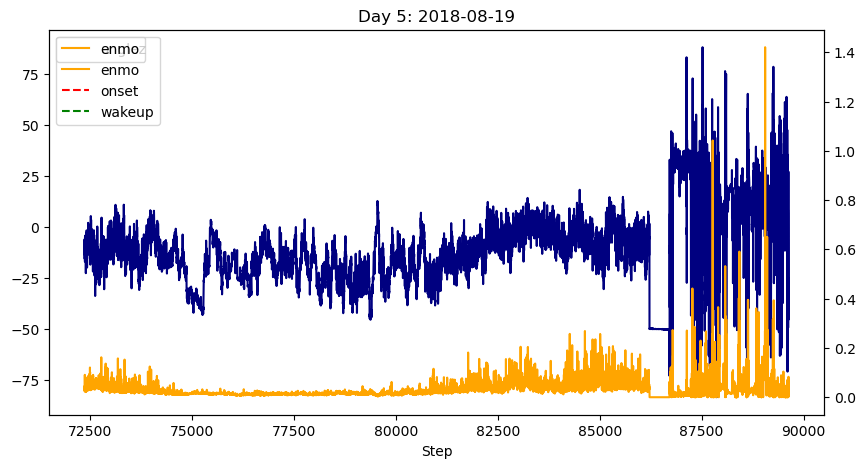

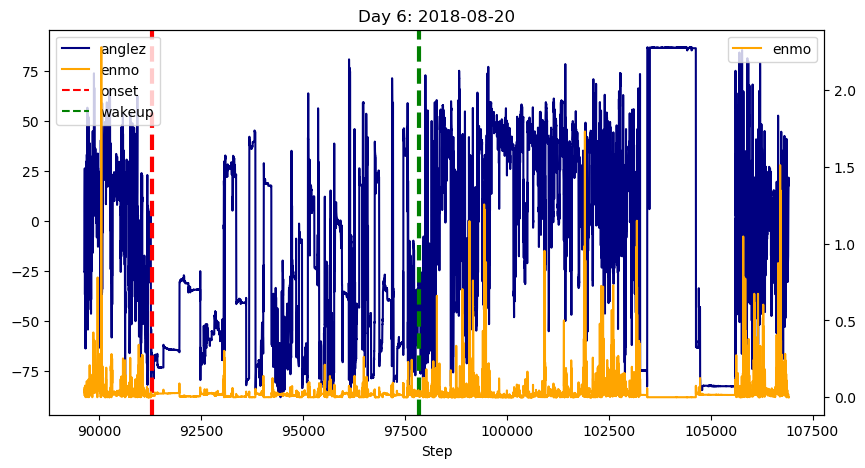

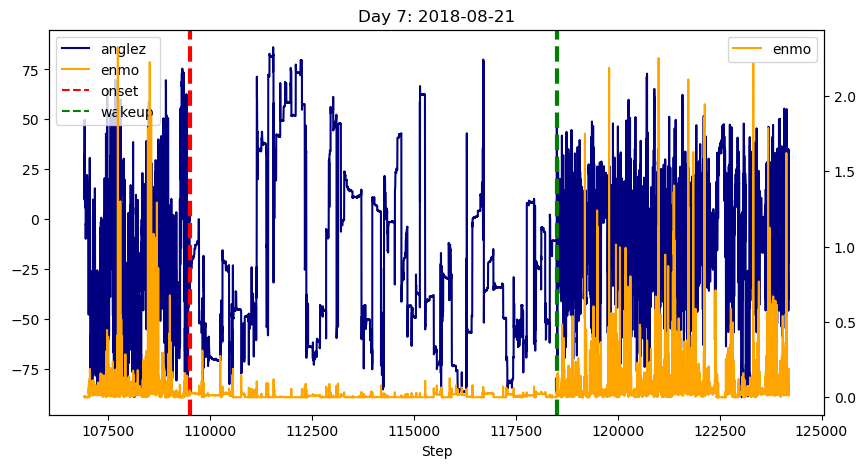

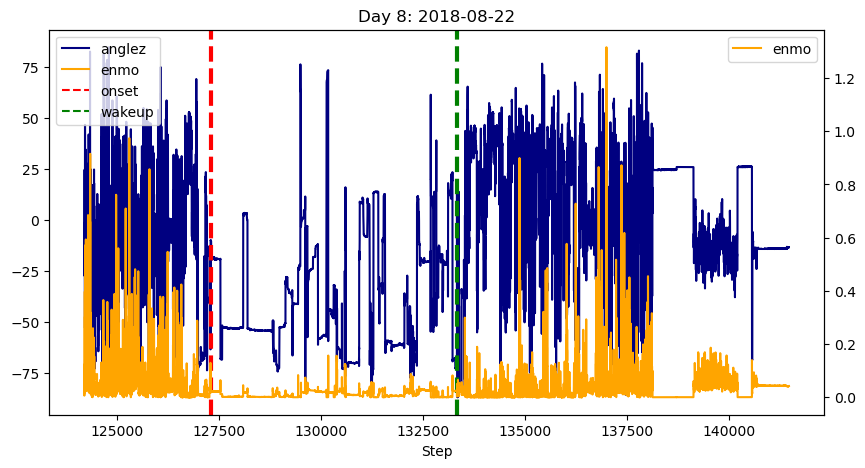

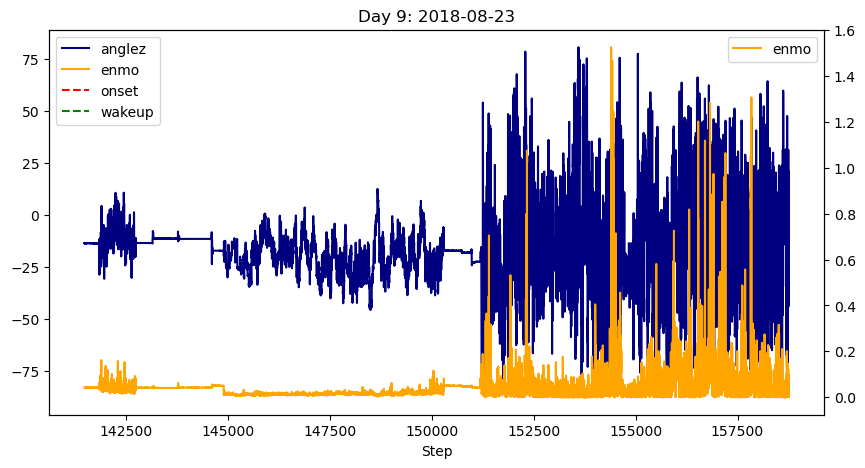

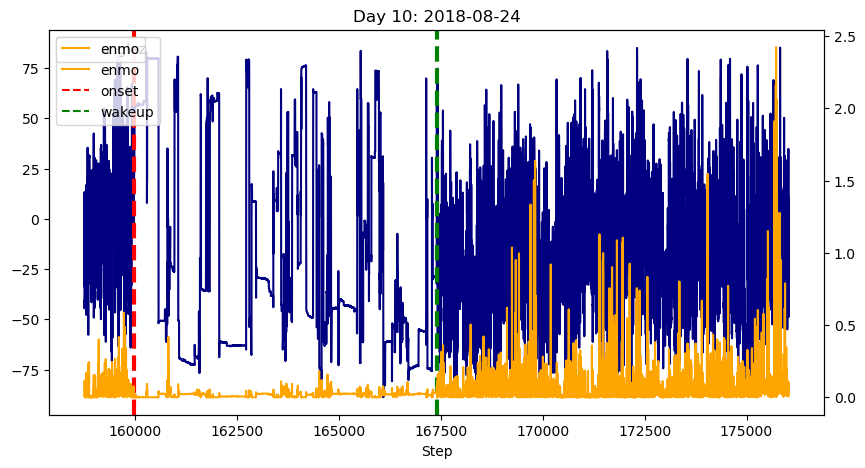

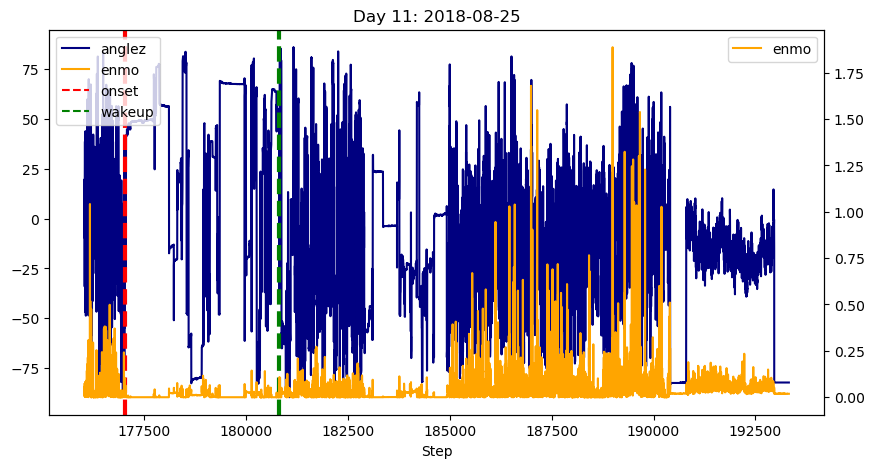

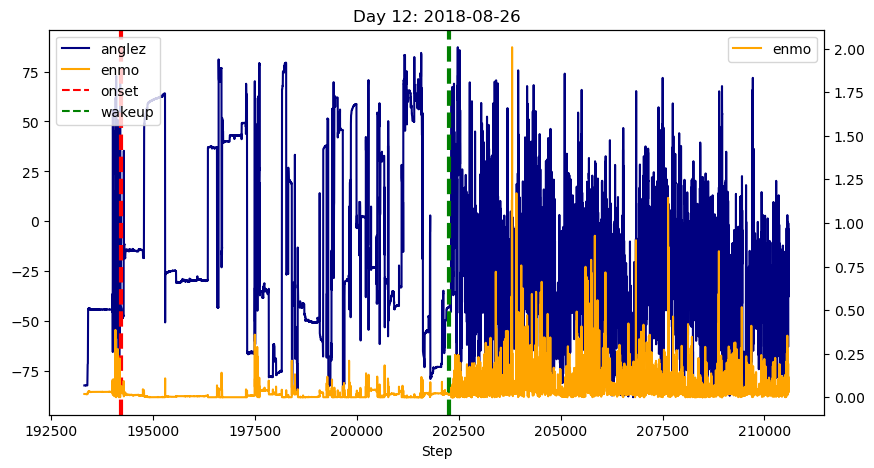

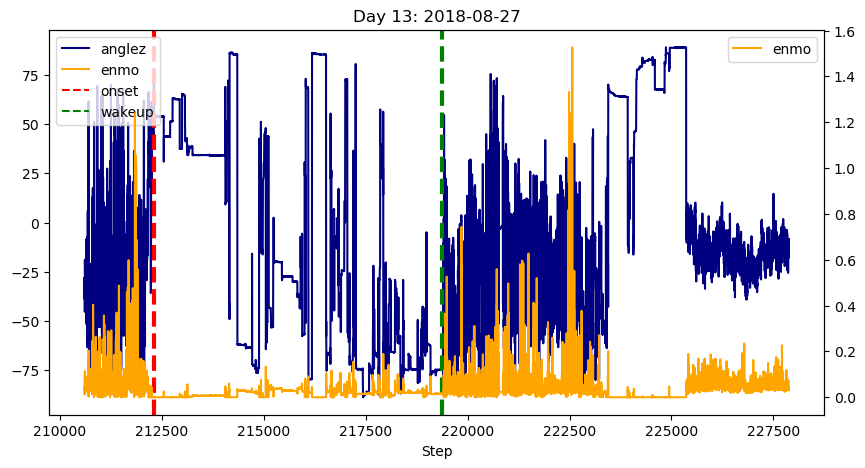

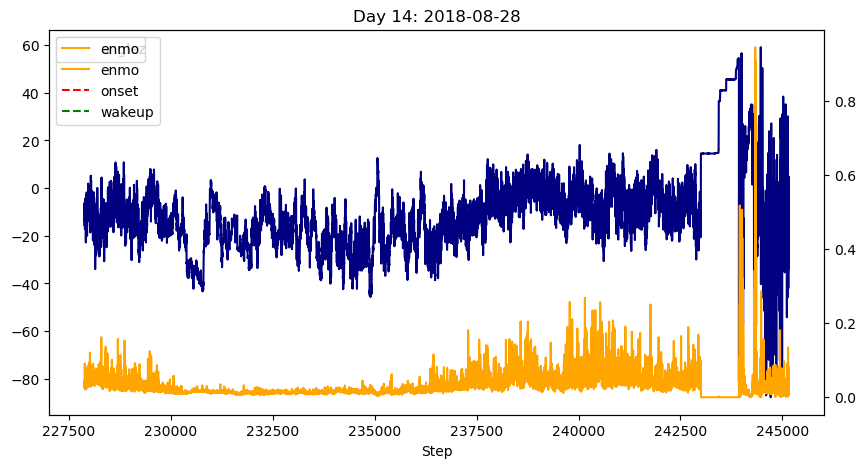

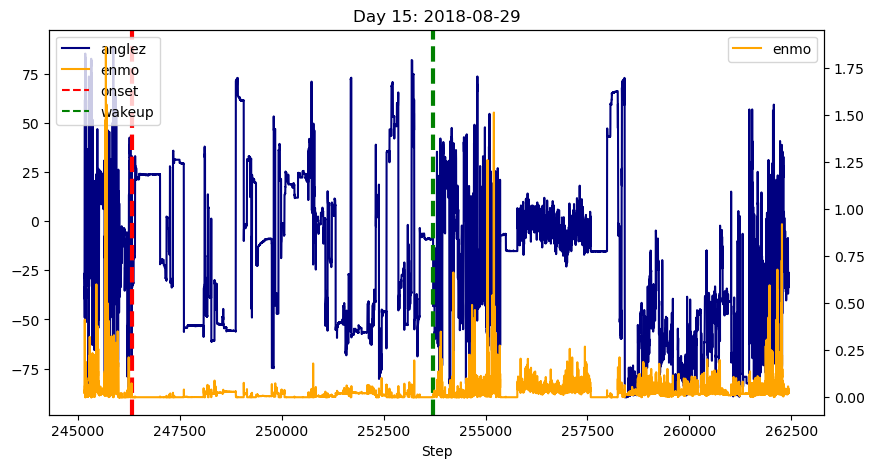

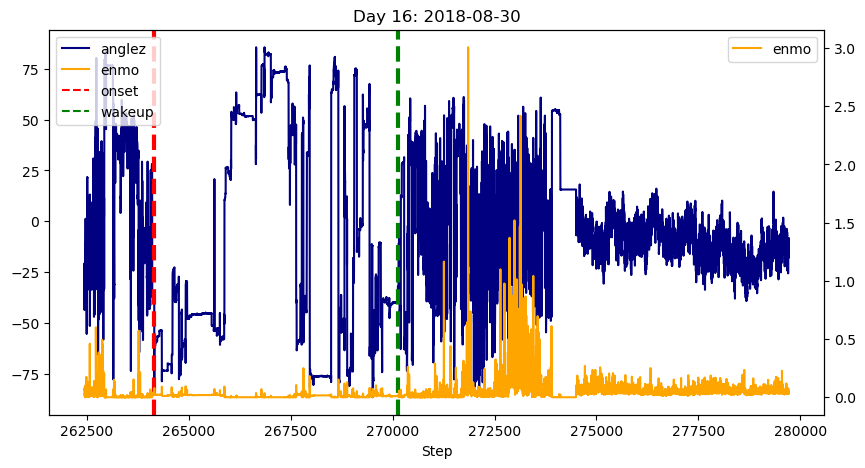

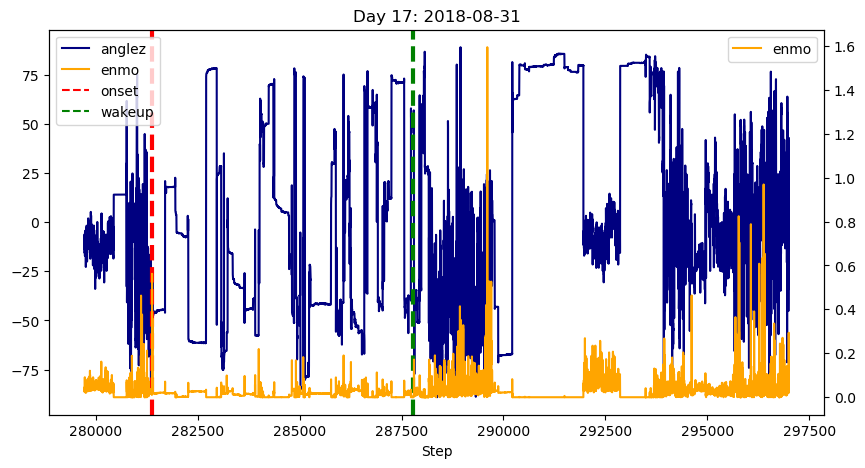

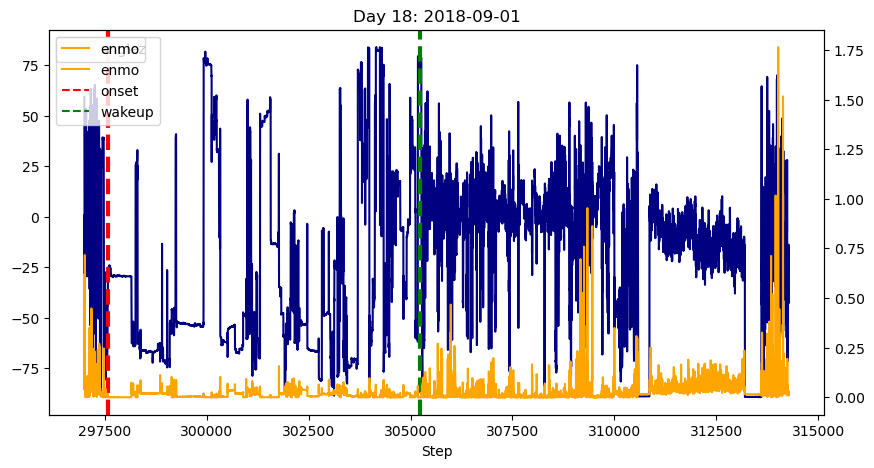

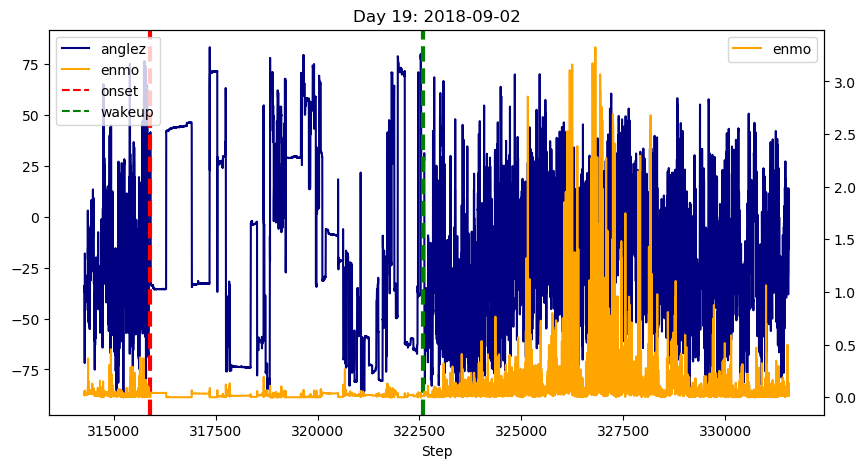

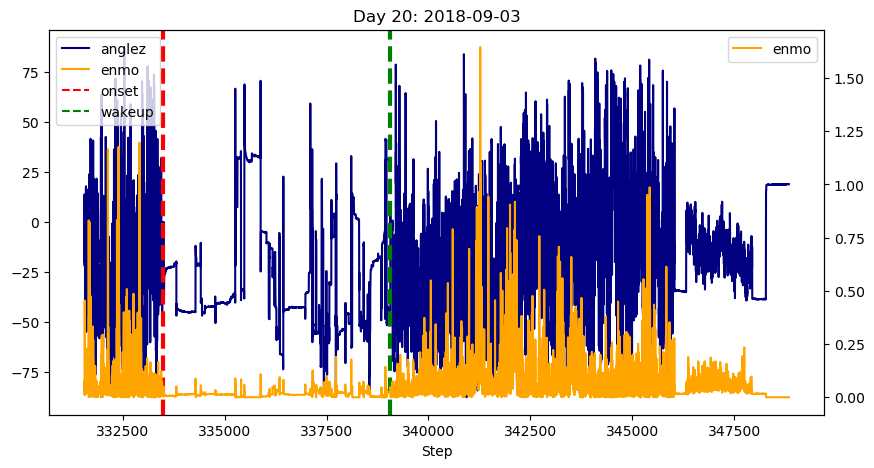

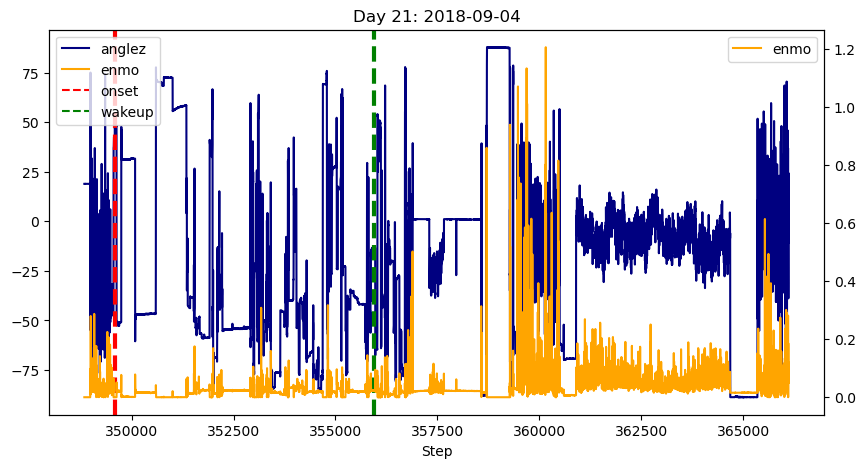

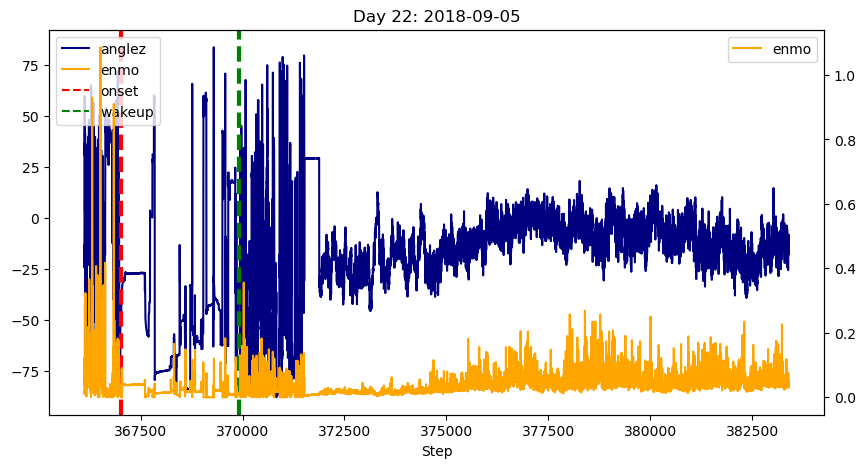

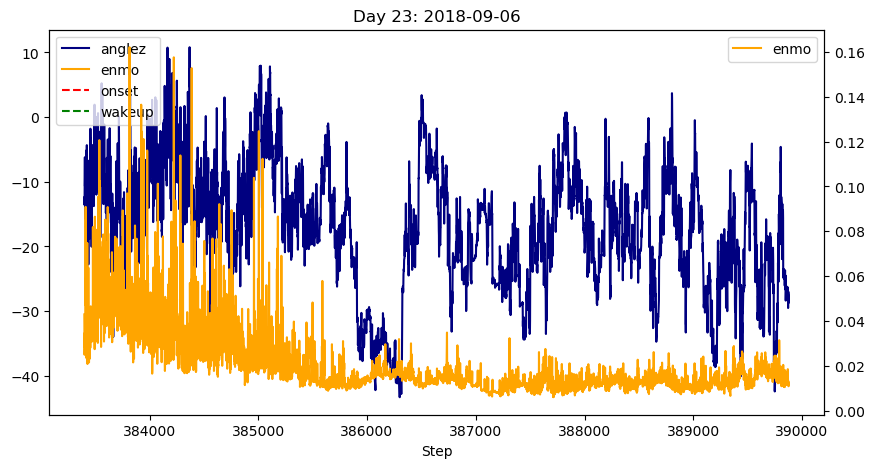

In [92]:
from matplotlib.lines import Line2D

# iterate through each date and row of data for the user
for i, (date, row) in enumerate(train_example.groupby('date')):

    # get first and last step for each date
    min_step = row['step'].min()
    max_step = row['step'].max()

    # get user id
    user_id = row[['series_id']].values[0][0]

    # plot anglez
    fig, ax = plt.subplots(figsize=(10, 5))
    row.set_index('step')[['anglez']].plot(ax=ax, title=f'Day {i}: {date}', color='navy', label='anglez')
    ax.set_xlabel('Step')
    # ax.legend(loc='upper left')

    # plot enmo
    ax2 = ax.twinx()
    row.set_index('step')[['enmo']].plot(ax=ax2, color='orange', label='enmo')
    # ax2.legend(loc='upper right')

    # get the onset and wakeup events for the day
    user_events = events.loc[(events['series_id'] == user_id) & (events['step'] >= min_step) & (events['step'] <= max_step)].reset_index(drop=True)

    # plot vertical lines for events
    onset_lines = []
    wakeup_lines = []
    for index, event in user_events.iterrows():
        if event['event'] == 'onset' and not onset_lines:
            ax.axvline(x=event['step'], color='red', linestyle='--', linewidth=3, label='onset')
            onset_lines.append(event['step'])
        elif event['event'] == 'wakeup' and not wakeup_lines:
            ax.axvline(x=event['step'], color='green', linestyle='--', linewidth=3, label='wakeup')
            wakeup_lines.append(event['step'])
        else:
            ax.axvline(x=event['step'], color='red' if event['event'] == 'onset' else 'green', linestyle='--', linewidth=3)
    
    # custom legends
    legend_elements = [Line2D([0], [0], color='navy', label='anglez'),
                       Line2D([0], [0], color='orange', label='enmo'),
                       Line2D([0], [0], color='red', linestyle='--', label='onset'),
                       Line2D([0], [0], color='green', linestyle='--', label='wakeup')]

    # add legend manually
    ax.legend(handles=legend_elements, loc='upper left')
    
    plt.show()

# Developing a model
We are not predicting onset and wakeup in __real time__ (like a normal time series task). We are given the full data, then we feed that data into a model to predict onset and wakeup at a specific step.

### Target definition:
- A single sleep period must be at least 30 minutes in length
- A single sleep period can be interrupted by bouts of activity that do not exceed 30 consecutive minutes
- No sleep windows can be detected unless the watch is deemed to be worn for the duration (elaborated upon, below)
- The longest sleep window during the night is the only one which is recorded
- If no valid sleep window is identifiable, neither an onset nor a wakeup event is recorded for that night.
- Sleep events do not need to straddle the day-line, and therefore there is no hard rule defining how many may occur within a given period. However, no more than one window should be assigned per night. For example, it is valid for an individual to have a sleep window from 01h00–06h00 and 19h00–23h30 in the same calendar day, though assigned to consecutive nights
- There are roughly as many nights recorded for a series as there are 24-hour periods in that series.

### First model
Goal: Create a classification model (non sequence) to classify if user is asleep or awake at each time step

- Drop null rows from events

- Label data (sleep/awake)
- Format so it can be used as input

- Add features (rolling features)

- Create simple model

In [114]:
# merge example with events table
train_final = train_example.merge(events.dropna(), how='left', on=['series_id', 'step']).drop(['timestamp_x', 'date', 'night', 'timestamp_y', 'tot_nights',
       'missing_sleep', 'tot_nights_missed'], axis=1)

In [115]:
# look at the rows where events occurred
train_final[train_final['event'].notna()].head()

,series_id,step,anglez,enmo,event
4992,038441c925bb,4992,-78.691,0.010,onset
10932,038441c925bb,10932,-61.578,0.026,wakeup
20244,038441c925bb,20244,-6.387,0.018,onset
27492,038441c925bb,27492,-45.355,0.016,wakeup
39996,038441c925bb,39996,-1.787,0.000,onset


In [116]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389880 entries, 0 to 389879
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   series_id  389880 non-null  object 
 1   step       389880 non-null  uint32 
 2   anglez     389880 non-null  float32
 3   enmo       389880 non-null  float32
 4   event      38 non-null      object 
dtypes: float32(2), object(2), uint32(1)
memory usage: 10.4+ MB


The majority of 'event' rows are null, as no event occurred at those. To address this, we forward fill the event column:

In [117]:
# forward fill the event column where sleep time is classified as 'onset' and awake time is classified as 'wakeup'
train_final['event'].ffill(inplace=True)

# fill the null rows at beginning with 'wakeup'
train_final.fillna('wakeup', inplace=True)

# check that all nulls are filled
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389880 entries, 0 to 389879
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   series_id  389880 non-null  object 
 1   step       389880 non-null  uint32 
 2   anglez     389880 non-null  float32
 3   enmo       389880 non-null  float32
 4   event      389880 non-null  object 
dtypes: float32(2), object(2), uint32(1)
memory usage: 10.4+ MB


Now, we'll check a few of the step indices where events occurred to ensure the forward fill worked correctly:

In [118]:
# check 1
train_final.set_index('step').loc[4990:4994]

,series_id,anglez,enmo,event
step,,,,
4990,038441c925bb,-78.710,0.010,wakeup
4991,038441c925bb,-78.730,0.010,wakeup
4992,038441c925bb,-78.691,0.010,onset
4993,038441c925bb,-78.665,0.010,onset
4994,038441c925bb,-78.466,0.010,onset


In [119]:
# check 2
train_final.set_index('step').loc[10930:10934]

,series_id,anglez,enmo,event
step,,,,
10930,038441c925bb,-58.177,0.036,onset
10931,038441c925bb,-61.438,0.027,onset
10932,038441c925bb,-61.578,0.026,wakeup
10933,038441c925bb,-61.744,0.026,wakeup
10934,038441c925bb,-61.786,0.027,wakeup


Now, we need to map these values to a sleep col to use as our final label:

In [120]:
# create sleep col
train_final['asleep'] = train_final['event'].apply(lambda x: 1 if x == 'onset' else 0)

The value count for awake times should be roughly double that of sleep time (16 hours awake, 8 hours asleep):

In [121]:
train_final['asleep'].value_counts()

asleep
0    269796
1    120084
Name: count, dtype: int64

In [122]:
# drop event col
train_final.drop('event', axis=1, inplace=True)

# final training dataframe (for a single user)
train_final.head()

,series_id,step,anglez,enmo,asleep
0,038441c925bb,0,2.637,0.022,0
1,038441c925bb,1,2.637,0.022,0
2,038441c925bb,2,2.637,0.022,0
3,038441c925bb,3,2.637,0.021,0
4,038441c925bb,4,2.637,0.022,0
